In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
pd.options.mode.chained_assignment = None

In [2]:
train = pd.read_csv("train.csv")
dfr = train.copy()

In [3]:
# kullanılmayan sütunlar kaldırıldı.
dfr.drop(dfr.iloc[:, 4:45], axis = 1, inplace=True)
dfr.drop(["target"], axis=1, inplace=True)
dfr

,id,comment_text,severe_toxicity
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000
1,59849,Thank you!! This would make my life a lot less...,0.000000
2,59852,This is such an urgent design problem; kudos t...,0.000000
3,59855,Is this something I'll be able to install on m...,0.000000
4,59856,haha you guys are a bunch of losers.,0.021277
...,...,...,...
1804869,6333967,"Maybe the tax on ""things"" would be collected w...",0.000000
1804870,6333969,What do you call people who STILL think the di...,0.000000
1804871,6333982,"thank you ,,,right or wrong,,, i am following ...",0.000000
1804872,6334009,Anyone who is quoted as having the following e...,0.030303


In [4]:
# class_id sütununa toxic seviyesi 0 olanları 0, 0' dan büyük olanları 1 olarak ekledik.
dfr["class_id"] = dfr["severe_toxicity"].apply(lambda x: 0 if x == 0 else 1)
#dfr['class_id'].value_counts()
# class_id_2 sütununa toxic seviyesi 0 olanları 0, 0.05'ten küçük olanları 1 diğerlerini 2 olarak kaydettik.
# 0 -> toksik değil
# 1 -> hafif toksik
# 2 -> aşırı toksik
dfr["class_id_2"] = dfr["severe_toxicity"].apply(lambda x: 0 if x == 0 else 1 if x < 0.05 else 2)
#dfr['class_id_2'].value_counts()

In [5]:
# sampling yapıldı.
data = dfr.groupby('class_id', group_keys=False).apply(lambda x: x.sample(frac = 0.008))
data['class_id'].value_counts()

0    13602
1      837
Name: class_id, dtype: int64

<AxesSubplot:xlabel='class_id'>

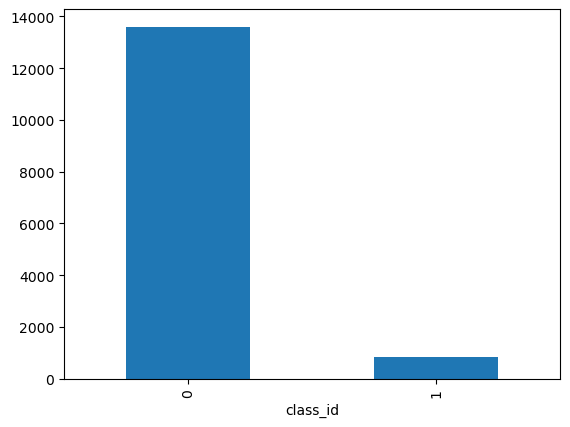

In [6]:
plt.figure()
plt.xlabel('class_id')
data['class_id'].value_counts().plot.bar()

In [7]:
# noktalama işaretlerinin kaldırılması
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

data["comment_text"] = data["comment_text"].apply(lambda text: remove_punctuation(text))

In [8]:
# sayıların kaldırılması
def remove_numbers(text):
    return ''.join(c for c in text if not c.isdigit())

data["comment_text"] = data["comment_text"].apply(lambda text: remove_numbers(text))

In [9]:
# stopwordslerin çıkarılması
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data["comment_text"] = data["comment_text"].apply(lambda text: remove_stopwords(text))

In [10]:
# stemming yapılması
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

data["comment_text"] = data["comment_text"].apply(lambda text: stem_words(text))

In [11]:
# en fazla 2 harf uzunluğunda olan kelimeler çıkarılması.
def remove_single_char_func(text, threshold):
    threshold = threshold
    text = ' '.join([word for word in text.split() if len(word) > threshold])
    return text

data["comment_text"] = data["comment_text"].apply(lambda text: remove_single_char_func(text, 2))

In [12]:
# Nadir kelimelerin kaldırılması
from collections import Counter

cnt = Counter()
for text in data["comment_text"].values:
    for word in text.split():
        cnt[word] += 1

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

data["comment_text"] = data["comment_text"].apply(lambda text: remove_rarewords(text))

In [13]:
# tokenization yapılması
regexp = RegexpTokenizer('\w+')

data['comment_text']=data['comment_text'].apply(regexp.tokenize)

In [14]:
# harflerin hepsini küçük harfe çevirme
data["comment_text"] = data["comment_text"].astype(str).str.lower()
data

,id,comment_text,severe_toxicity,class_id,class_id_2
179313,460835,"['your', 'right', 'wavemak', 'let', 'sit', 'ha...",0.000000,0,0
541920,906201,"['onc', 'msm', 'convert', 'put', 'assert', 'go...",0.000000,0,0
490120,844766,"['law', 'httpswwwadncomcommentaryarticlealaska...",0.000000,0,0
539295,902981,"['richard', 'wright', 'claim', 'fals', 'the', ...",0.000000,0,0
750958,5040065,"['ill', 'tri', 'best', 'make', 'one', 'civil',...",0.000000,0,0
...,...,...,...,...,...
1648952,6143217,"['now', 'kill', 'the', 'old', 'and', 'sick', '...",0.078125,1,2
363997,688854,"['scari', 'anyon', 'would', 'take', 'recommend...",0.166667,1,2
1246852,5638476,"['anyon', 'technic', 'work', 'must', 'licens',...",0.100000,1,2
1492404,5946750,"['what', 'rubbish', 'serious', 'mean', 'defin'...",0.012500,1,1


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer() 
vectors = vectorizer.fit_transform(data["comment_text"])

print("samples: %d, features: %d" % vectors.shape)

samples: 14439, features: 24439


In [16]:
tf_idf = pd.DataFrame(vectors.todense()) 
tf_idf.columns = vectorizer.get_feature_names_out()
tfidf_matrix = tf_idf.T
tfidf_matrix.columns = [str(i) for i in range(1, 14440)]
tfidf_matrix['count'] = tfidf_matrix.sum(axis=1)
tfidf_matrix = tfidf_matrix.sort_values(by ='count', ascending=False)
tfidf_matrix.drop(["count"], axis=1, inplace=True)
matrix = tfidf_matrix.T
matrix

,the,like,peopl,would,one,trump,get,dont,you,think,...,amort,crossroad,bigey,hawaiibas,galley,stevefor,onu,gouvern,annexeal,freecultur
1,0.000000,0.000000,0.000000,0.093710,0.093467,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.064650,0.000000,0.072559,0.067444,0.000000,0.076169,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.058451,0.000000,0.067847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.161104,0.000000,0.084252,0.088288,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14435,0.231320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.315191,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14436,0.043913,0.100493,0.050972,0.101571,0.151960,0.056999,0.000000,0.111036,0.000000,0.058468,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076049,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

x = matrix
y = data["class_id"]

chi2_features = SelectKBest(chi2, k = 5000)
a = chi2_features.fit_transform(x, y)

mask = chi2_features.get_support()
new_features = []
for bool, feature in zip(mask, x.columns):
    if bool:
        new_features.append(feature)

veri = pd.DataFrame(x, columns=new_features)
veriClus = veri.copy()
veri

,like,peopl,would,one,trump,get,you,time,year,good,...,faceoff,playbyplay,couldvewouldv,meek,demaryiu,ndand,wassilli,vspo,alcoholfuel,onu
1,0.000000,0.000000,0.093710,0.093467,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.064650,0.000000,0.072559,0.067444,0.076169,0.000000,0.07373,0.078836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.067847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.000000,0.161104,0.000000,0.084252,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.315191,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14436,0.100493,0.050972,0.101571,0.151960,0.056999,0.000000,0.000000,0.057217,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078376,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
from sklearn.model_selection import train_test_split

X = veri
Y = data["class_id"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [19]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn.fit(X_train,Y_train)
knn_Y_pred = knn.predict(X_test)

knnF = pd.DataFrame({'gerçek değer': Y_test, 'tahmin değer': knn_Y_pred})
knnF

,gerçek değer,tahmin değer
1440538,0,0
19122,0,0
743382,0,0
683746,0,0
724265,0,0
...,...,...
921055,0,0
104332,0,0
1155467,0,0
1740895,0,0


In [20]:
# KNN performans değerlendirmesi
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

accuracy = accuracy_score(Y_test, knn_Y_pred)
print('Accuracy: %.3f' % accuracy)

f_measure = f1_score(Y_test, knn_Y_pred, average='weighted', labels=np.unique(knn_Y_pred))
print('F_measure: %.3f' % f_measure)

recall = recall_score(Y_test, knn_Y_pred, average='weighted', labels=np.unique(knn_Y_pred))
print('Recall: %.3f' % recall)

precision = precision_score(Y_test, knn_Y_pred, average='weighted', labels=np.unique(knn_Y_pred))
print('Precision: %.3f' % precision)

cv_scores = cross_val_score(knn, X, Y, cv=5)
print('Cross_val_score mean: %.3f' % np.mean(cv_scores))

Accuracy: 0.945
F_measure: 0.919
Recall: 0.945
Precision: 0.948
Cross_val_score mean: 0.942


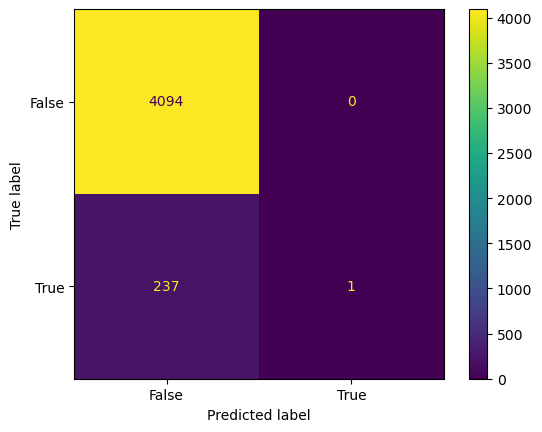

In [22]:
# Knn confusion matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(Y_test, knn_Y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [23]:
# SVM
from sklearn import svm

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train, Y_train)
svm_Y_pred = SVM.predict(X_test)

svmF = pd.DataFrame({'gerçek değer': Y_test, 'tahmin değer': svm_Y_pred})
svmF

,gerçek değer,tahmin değer
1440538,0,0
19122,0,0
743382,0,0
683746,0,0
724265,0,0
...,...,...
921055,0,0
104332,0,0
1155467,0,0
1740895,0,0


In [24]:
# SVM performans değerlendirmesi
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

accuracy = accuracy_score(Y_test, svm_Y_pred)
print('Accuracy: %.3f' % accuracy)

f_measure = f1_score(Y_test, svm_Y_pred)
print('F_measure: %.3f' % f_measure)

recall = recall_score(Y_test, svm_Y_pred)
print('Recall: %.3f' % recall)

precision = precision_score(Y_test, svm_Y_pred)
print('Precision: %.3f' % precision)

cv_scores = cross_val_score(SVM, X, Y, cv=5)
print('Cross_val_score mean: %.3f' % np.mean(cv_scores))

Accuracy: 0.947
F_measure: 0.109
Recall: 0.059
Precision: 0.737
Cross_val_score mean: 0.945


In [ ]:
from sklearn.metrics import classification_report
print( classification_report(Y_test, svm_Y_pred))

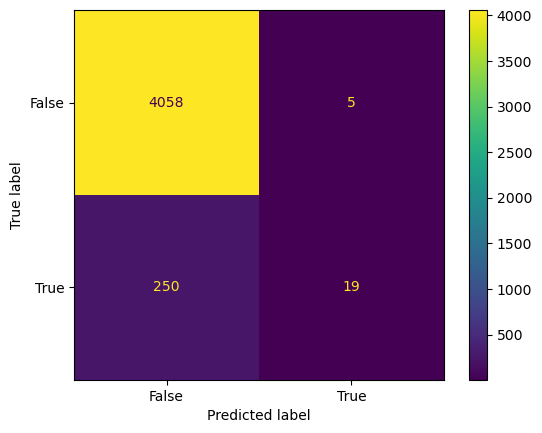

In [53]:
# Svm confusion matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(Y_test, svm_Y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [54]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, Y_train)
nb_Y_pred = nb.predict(X_test)

nbF = pd.DataFrame({'gerçek değer': Y_test, 'tahmin değer': nb_Y_pred})
nbF

,gerçek değer,tahmin değer
1471386,0,0
1431946,0,0
655599,0,0
1672,0,0
1131451,1,0
...,...,...
976763,0,0
970244,1,0
83333,0,0
263534,0,0


In [55]:
# Naive Bayes performans değerlendirmesi
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

accuracy = accuracy_score(Y_test, nb_Y_pred)
print('Accuracy: %.3f' % accuracy)

f_measure = f1_score(Y_test, nb_Y_pred, average='weighted', labels=np.unique(nb_Y_pred))
print('F_measure: %.3f' % f_measure)

recall = recall_score(Y_test, nb_Y_pred, average='weighted', labels=np.unique(nb_Y_pred))
print('Recall: %.3f' % recall)

precision = precision_score(Y_test, nb_Y_pred, average='weighted', labels=np.unique(nb_Y_pred))
print('Precision: %.3f' % precision)

cv_scores = cross_val_score(nb, X, Y, cv=5)
print('Cross_val_score mean: %.3f' % np.mean(cv_scores))

Accuracy: 0.938
F_measure: 0.968
Recall: 1.000
Precision: 0.938
Cross_val_score mean: 0.942


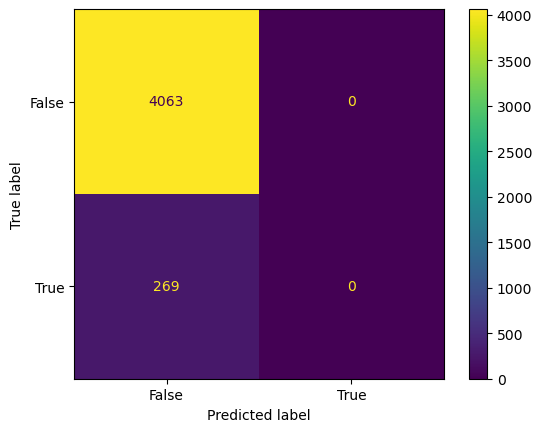

In [56]:
# Naive Bayes confusion matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(Y_test, nb_Y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [20]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion = 'entropy')
dt.fit(X_train, Y_train)
dt_Y_pred = dt.predict(X_test)

dtF = pd.DataFrame({'gerçek değer': Y_test, 'tahmin değer': dt_Y_pred})
dtF

,gerçek değer,tahmin değer
704469,0,0
1747002,0,0
79250,0,0
1632050,0,0
86991,0,0
...,...,...
472497,0,0
270233,0,0
206555,0,0
211274,0,0


In [21]:
# Decision Tree performans değerlendirmesi
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

accuracy = accuracy_score(Y_test, dt_Y_pred)
print('Accuracy: %.3f' % accuracy)

f_measure = f1_score(Y_test, dt_Y_pred)
print('F_measure: %.3f' % f_measure)

recall = recall_score(Y_test, dt_Y_pred)
print('Recall: %.3f' % recall)

precision = precision_score(Y_test, dt_Y_pred)
print('Precision: %.3f' % precision)

cv_scores = cross_val_score(dt, X, Y, cv=5)
print('Cross_val_score mean: %.3f' % np.mean(cv_scores))

Accuracy: 0.928
F_measure: 0.265
Recall: 0.234
Precision: 0.306
Cross_val_score mean: 0.927


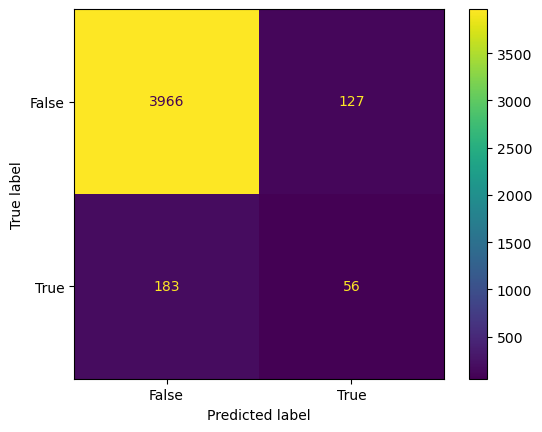

In [22]:
# Decision tree confusion matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(Y_test, dt_Y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [23]:
# Linear Regression
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train, Y_train)

linreg_Y_pred = linreg.predict(X_test)

In [24]:
# Linear Regression performans değerlendirmesi
from sklearn.metrics import recall_score,precision_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

r2 = r2_score(Y_test, linreg_Y_pred)
print('R2_score: %.3f' % r2)

mse = mean_squared_error(Y_test, linreg_Y_pred)
print('MSE: %.3f' % mse)

mae = mean_absolute_error(Y_test, linreg_Y_pred)
print('MAE: %.3f' % mae)

cv_scores = cross_val_score(linreg, X, Y, cv=5)
print('Cross_val_score mean: %.3f' % np.mean(cv_scores))

R2_score: -12095623961314575972827136.000
MSE: 630508617013463873486848.000
MAE: 132233483034.666
Cross_val_score mean: -0.082


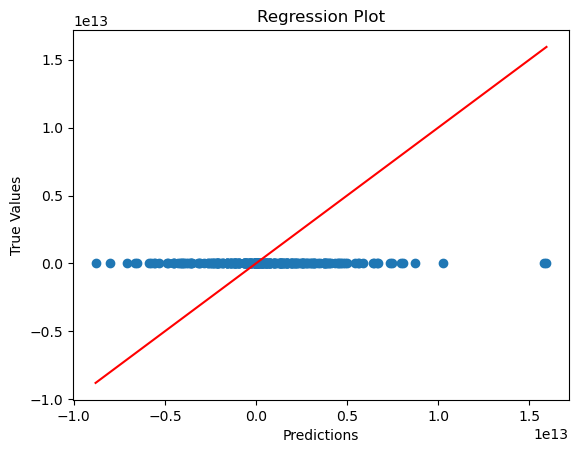

In [25]:
plt.scatter(linreg_Y_pred, Y_test)
x = np.linspace(min(linreg_Y_pred), max(linreg_Y_pred))
y = x
plt.plot(x, y, color='red')

plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Regression Plot')
plt.show()

In [35]:
# class_id_2 için train_test_split
from sklearn.model_selection import train_test_split

X2 = veri
Y2 = data["class_id_2"]

x_train, x_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.3)

In [38]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski')
knn.fit(x_train,y_train)
knn_y_pred = knn.predict(x_test)

knnF = pd.DataFrame({'gerçek değer': y_test, 'tahmin değer': knn_y_pred})
knnF

,gerçek değer,tahmin değer
1415521,0,0
174890,0,0
310174,0,0
1638450,0,0
543116,0,0
...,...,...
163956,0,0
57206,0,0
1040053,0,0
1366687,0,0


In [39]:
# KNN performans değerlendirmesi
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

accuracy = accuracy_score(y_test, knn_y_pred)
print('Accuracy: %.3f' % accuracy)

f_measure = f1_score(y_test, knn_y_pred, average='weighted', labels=np.unique(knn_y_pred))
print('F_measure: %.3f' % f_measure)

recall = recall_score(y_test, knn_y_pred, average='weighted', labels=np.unique(knn_y_pred))
print('Recall: %.3f' % recall)

precision = precision_score(y_test, knn_y_pred, average='weighted', labels=np.unique(knn_y_pred))
print('Precision: %.3f' % precision)

cv_scores = cross_val_score(knn, X2, Y2, cv=5)
print('Cross_val_score mean: %.3f' % np.mean(cv_scores))

Accuracy: 0.940
F_measure: 0.946
Recall: 0.976
Precision: 0.933
Cross_val_score mean: 0.942


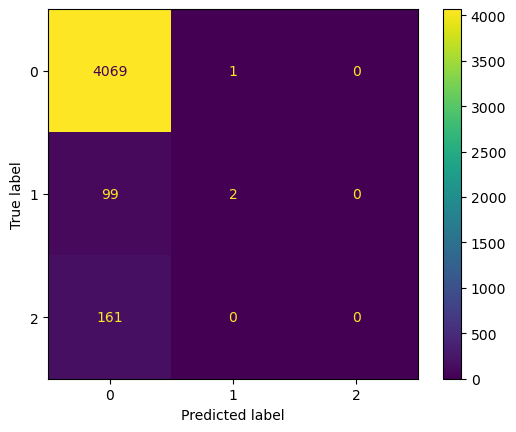

In [41]:
# Knn confusion matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, knn_y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [42]:
# SVM
from sklearn import svm

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(x_train, y_train)
svm_y_pred = SVM.predict(x_test)

svmF = pd.DataFrame({'gerçek değer': y_test, 'tahmin değer': svm_y_pred})
svmF

,gerçek değer,tahmin değer
1415521,0,0
174890,0,0
310174,0,0
1638450,0,0
543116,0,0
...,...,...
163956,0,0
57206,0,0
1040053,0,0
1366687,0,0


In [45]:
# SVM performans değerlendirmesi
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

accuracy = accuracy_score(y_test, svm_y_pred)
print('Accuracy: %.3f' % accuracy)

f_measure = f1_score(y_test, svm_y_pred, average='weighted', labels=np.unique(svm_y_pred))
print('F_measure: %.3f' % f_measure)

recall = recall_score(y_test, svm_y_pred, average='weighted', labels=np.unique(svm_y_pred))
print('Recall: %.3f' % recall)

precision = precision_score(y_test, svm_y_pred, average='weighted', labels=np.unique(svm_y_pred))
print('Precision: %.3f' % precision)

cv_scores = cross_val_score(SVM, X2, Y2, cv=5)
print('Cross_val_score mean: %.3f' % np.mean(cv_scores))

Accuracy: 0.940
F_measure: 0.913
Recall: 0.940
Precision: 0.938
Cross_val_score mean: 0.944


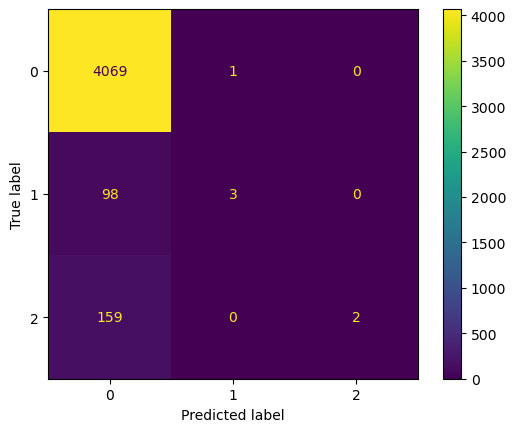

In [46]:
# Svm confusion matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, svm_y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [47]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(x_train, y_train)
nb_y_pred = nb.predict(x_test)

nbF = pd.DataFrame({'gerçek değer': y_test, 'tahmin değer': nb_y_pred})
nbF

,gerçek değer,tahmin değer
1415521,0,0
174890,0,0
310174,0,0
1638450,0,0
543116,0,0
...,...,...
163956,0,0
57206,0,0
1040053,0,0
1366687,0,0


In [48]:
# Naive Bayes performans değerlendirmesi
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

accuracy = accuracy_score(y_test, nb_y_pred)
print('Accuracy: %.3f' % accuracy)

f_measure = f1_score(y_test, nb_y_pred, average='weighted', labels=np.unique(nb_y_pred))
print('F_measure: %.3f' % f_measure)

recall = recall_score(y_test, nb_y_pred, average='weighted', labels=np.unique(nb_y_pred))
print('Recall: %.3f' % recall)

precision = precision_score(y_test, nb_y_pred, average='weighted', labels=np.unique(nb_y_pred))
print('Precision: %.3f' % precision)

cv_scores = cross_val_score(nb, X2, Y2, cv=5)
print('Cross_val_score mean: %.3f' % np.mean(cv_scores))

Accuracy: 0.940
F_measure: 0.969
Recall: 1.000
Precision: 0.940
Cross_val_score mean: 0.942


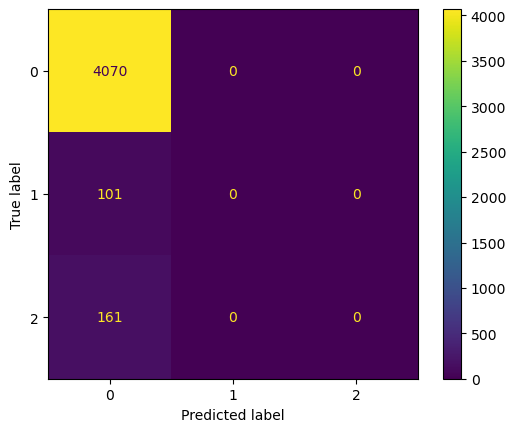

In [49]:
# Naive Bayes confusion matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, nb_y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [50]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion = 'entropy')
dt.fit(x_train, y_train)
dt_y_pred = dt.predict(x_test)

dtF = pd.DataFrame({'gerçek değer': y_test, 'tahmin değer': dt_y_pred})
dtF

,gerçek değer,tahmin değer
1415521,0,0
174890,0,0
310174,0,0
1638450,0,0
543116,0,0
...,...,...
163956,0,0
57206,0,0
1040053,0,0
1366687,0,0


In [52]:
# Decision Tree performans değerlendirmesi
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

accuracy = accuracy_score(y_test, dt_y_pred)
print('Accuracy: %.3f' % accuracy)

f_measure = f1_score(y_test, dt_y_pred, average='weighted', labels=np.unique(dt_y_pred))
print('F_measure: %.3f' % f_measure)

recall = recall_score(y_test, dt_y_pred, average='weighted', labels=np.unique(dt_y_pred))
print('Recall: %.3f' % recall)

precision = precision_score(y_test, dt_y_pred, average='weighted', labels=np.unique(dt_y_pred))
print('Precision: %.3f' % precision)

cv_scores = cross_val_score(dt, X2, Y2, cv=5)
print('Cross_val_score mean: %.3f' % np.mean(cv_scores))

Accuracy: 0.924
F_measure: 0.917
Recall: 0.924
Precision: 0.911
Cross_val_score mean: 0.923


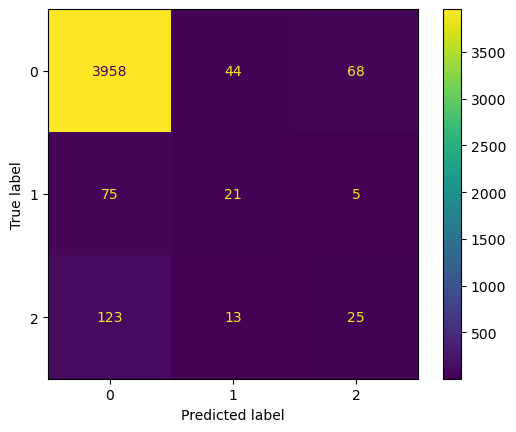

In [53]:
# Decision tree confusion matrix
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, dt_y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [54]:
# Linear Regression
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(x_train, y_train)

linreg_y_pred = linreg.predict(x_test)

In [55]:
# Linear Regression performans değerlendirmesi
from sklearn.metrics import recall_score,precision_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

r2 = r2_score(y_test, linreg_y_pred)
print('R2_score: %.3f' % r2)

mse = mean_squared_error(y_test, linreg_y_pred)
print('MSE: %.3f' % mse)

mae = mean_absolute_error(y_test, linreg_y_pred)
print('MAE: %.3f' % mae)

cv_scores = cross_val_score(linreg, X2, Y2, cv=5)
print('Cross_val_score mean: %.3f' % np.mean(cv_scores))

R2_score: -6442264516903824772825088.000
MSE: 1046490227242268180348928.000
MAE: 144574473757.783
Cross_val_score mean: -0.073


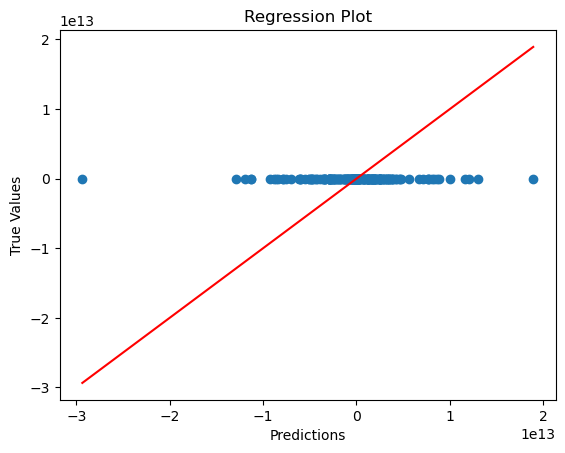

In [56]:
plt.scatter(linreg_y_pred, y_test)
x = np.linspace(min(linreg_y_pred), max(linreg_y_pred))
y = x
plt.plot(x, y, color='red')

plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Regression Plot')
plt.show()

In [26]:
# Kmeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(veriClus)
kmeans_Y_pred = kmeans.predict(veriClus)

from sklearn.metrics import silhouette_score

score = silhouette_score(veriClus, kmeans_Y_pred)
print('Silhouette score: %.3f' % score)

Silhouette score: 0.018


In [34]:
# Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

HClustering = AgglomerativeClustering(n_clusters=2, linkage="average", affinity='euclidean')
HClustering.fit(veriClus)
hc_Y_pred = HClustering.fit_predict(veriClus)

score = silhouette_score(veriClus, hc_Y_pred)
print('Silhouette score: %.3f' % score)

Silhouette score: 0.164
